In [1]:
import numpy as np
import xmlTranslator as xmlT
from tqdm import tqdm
%reload_ext autoreload
%autoreload 2
import importlib
from utils import get_project_root
from ipywidgets import FloatProgress

TODO: 
- Repeat the sequences 3 times
- Extend all chords into 18 enharmonic
- Complete the voicing as a MIDI array 
- Split into train and test
- Pass the MIDI into Embeddings

In [69]:
directory = '/data/iRealXML'
root = get_project_root()
myPath = str(root) + str(directory)

theChordDataset, theDurationsDataset, all_meta = xmlT.parse_info_from_XML(myPath)

  0%|          | 0/4007 [00:00<?, ?it/s]

(4006,) (4006,) (4006,)


In [70]:
#Correct the location of 'e||'
dataset = []
dataset_durations = []
for i, song in enumerate(theChordDataset):
    d = theDurationsDataset[i]
    song, durations = xmlT.correct_coda_end(song, d)
    dataset.append(song)
    dataset_durations.append(durations)
print(len(dataset), len(dataset_durations))

4006 4006


In [4]:
id = 204
print(all_meta[id])
print(len(dataset[id]))
print(dataset[id].tolist())

{'composer': 'Israel Houghton', 'style': 'Worship', 'song_name': 'Alpha And Omega', 'tonality': 'Db major', 'midi_key': 13, 'time_signature': '4/4', 'decade': 'Null'}
134
['<style>', 'Worship', 'Form_A', '|:', '.', 'Db', 'major', '|', '.', 'Ab', 'major', '/', 'C', '.', 'Db', 'major', '.', 'Eb', 'minor-seventh', '|', '.', 'Db', 'major', '.', 'Db', 'major', '/', 'F', '|', '.', 'Gb', 'major', '.', 'Eb', 'minor', '/', 'Gb', '.', 'Eb', 'minor', '|', '.', 'Db', 'major', '/', 'Ab', '.', 'Db', 'major', '/', 'Ab', '.', 'Bb', 'minor', '/', 'Ab', '|', '.', 'Ab', 'major', '.', 'Bb', 'minor', '.', 'Ab', 'major', '/', 'C', '|', '.', 'Db', 'major', '.', 'C', 'minor-seventh', 'alter b5', '.', 'F', 'dominant', 'Form_B', '|', '.', 'Bb', 'minor', '|', '.', 'Ab', 'major', '.', 'Gb', 'major', '|', '.', 'Db', 'major', '/', 'F', '|', '.', 'Gb', 'major', '.', 'Eb', 'minor', '/', 'Gb', '.', 'Eb', 'minor', '|', '.', 'Db', 'major', '/', 'Ab', '|', '.', 'Ab', 'major', '.', 'Bb', 'minor', '.', 'Ab', 'major', '/', 

In [71]:
'''
This section expands the song following the rules of bar repetitions and coda endings
'''
importlib.reload(xmlT)

id = 0
expand_form_dataset = []
expand_duration_dataset = []
status = True
for i in tqdm(range(len(dataset))):
    song_structure, duration_structure, status = xmlT.expand_song_structure(dataset[i], dataset_durations[i], i, False)
    if status == False:
        print('Song:', all_meta[i])
        id = i
        break
    song_structure = np.array(song_structure)
    duration_structure = np.array(duration_structure)
    expand_form_dataset.append(song_structure)
    expand_duration_dataset.append(duration_structure)

#check if all elements are the same size
for i in range(len(expand_form_dataset)):
    if len(expand_form_dataset) != len(expand_duration_dataset):
        print('Error in:', i)
        break

  0%|          | 0/4006 [00:00<?, ?it/s]

100%|██████████| 4006/4006 [00:01<00:00, 2697.51it/s]


In [72]:
sub_sections = dataset[4005:4006]
sub_durations = dataset_durations[4005:4006]
for i in range(len(sub_sections)):
    a,b,s = xmlT.expand_song_structure(sub_sections[i], sub_durations[i], i, True)
print(a)

Song: 0 
Length of sequence: 232
First coda passed at: 134
Moved to Head from 173 0
Second time goes to Coda at: 173
Process completed successfully.. New form length: 366
-----------------------------

['<style>', 'Ballad', 'Form_A', '|', '.', 'C', 'major', '.', 'E', 'minor', '/', 'B', '|', '.', 'B', 'suspended-fourth', '.', 'B', 'major', '.', 'B', 'major', '/', 'A', '|', '.', 'G', 'major', '.', 'C', 'major-seventh', '|', '.', 'C#', 'minor-seventh', 'alter b5', '.', 'G', 'major-seventh', '/', 'D', '|', '.', 'D', 'major', '/', 'F#', '.', 'C', 'major', '/', 'E', '|', '.', 'C', 'minor', '/', 'Eb', '.', 'G', 'major', '/', 'D', '|', '.', 'C#', 'minor-seventh', 'alter b5', '.', 'F#', 'dominant', '/', 'C#', '|', '.', 'B', 'major', '.', 'A', 'minor-seventh', '.', 'D', 'dominant', '/', 'A', 'Form_B', '|', '.', 'G', 'major', 'add 9', '.', 'D', 'major', '/', 'F#', '|', '.', 'C', 'major-seventh', '/', 'E', '.', 'C#', 'minor-seventh', 'alter b5', '|', '.', 'G', 'major', '/', 'D', '.', 'B', 'dominan

In [73]:
#Unify chord and duration into a tuple as good friends
dataset = []
for chords_values, durations_values in zip(expand_form_dataset, expand_duration_dataset):
    coupled = list(zip(chords_values, durations_values))
    dataset.append(coupled)    

In [112]:
#correct the wrong chords
importlib.reload(xmlT)

corrected_sequence = xmlT.replaceTheseChords(dataset, False)

  0%|          | 0/4006 [00:00<?, ?it/s]

In [ ]:
id = 4005
name = all_meta[id]
test = corrected_sequence[id]

for e in test:
    print(e)

In [113]:
#Add the token Maj to those single notes that are not clarified.
import voicing as vc
voicing = vc.Voicing()
new_dataset = []
id = 4005
#id = 2686
name = all_meta[id]['song_name']

print(name)

for x, song in enumerate(tqdm(corrected_sequence)):
    sequence = []
    for i, item in enumerate(song):
        sequence.append(item)
        chord = item[0]
        duration = item[1]
        next = ''
        if i < len(song) - 1:
            next = song[i + 1][0]
            previous = song[i - 1][0]
            if chord in voicing.all_notes and previous != '/' and (next in voicing.structural_elements or next.startswith('Form_')):
                sequence.append(('maj', duration))
                #print(x, 'Added Maj to:', chord, 'at position:', i)
        elif i == len(song) - 1:
            previous = song[i - 1][0]
            if chord in voicing.all_notes and previous != '/':
                sequence.append(('maj', duration))
                #print(x, 'Added Maj to:', chord, 'at position:', i)
    new_dataset.append(sequence)
    
# for e in new_dataset:
#     for a in e:
#         print(a)

Message To A Friend


100%|██████████| 4006/4006 [00:00<00:00, 4009.26it/s]


In [114]:
#clean the elements that are ''
dataset = [[tup for tup in inner_list if tup[0] != ''] for inner_list in new_dataset]

print(len(dataset))
print(dataset[0])

for song in dataset:
    for i, e in enumerate(song):
        if e[0] == '':
            print(song)
            print(i)
            break

4006
[('<style>', 0.0), ('Medium Swing', 0.0), ('|', 0.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m7', 4.0), ('|', 4.0), ('.', 4.0), ('Bb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('maj', 4.0), ('|', 0.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m7', 4.0), ('|', 4.0), ('.', 4.0), ('Bb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 2.0), ('A', 2.0), ('m7', 2.0), ('.', 2.0), ('D', 2.0), ('dom7', 2.0), ('|', 2.0), ('.', 4.0), ('G', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 2.0), ('A', 2.0), ('m7', 2.0), (

In [115]:
'''
This section is important to define a more concise format and tokenization.
Fix the format of extensions to avoid repeated elements
'''

xmlT.fix_extensions(dataset)

  0%|          | 0/4006 [00:00<?, ?it/s]

In [116]:
#Check vocabulary
chords_array = [[item[0] for item in row] for row in dataset]
concatenated_array = np.hstack(chords_array) 
vocab = set(concatenated_array)

print(len(vocab))
print(np.array(vocab))

202
{'Medium Up', 'Medium Country', 'Medium Ballad', 'major-13th', 'Funk Rock', 'Montuno', 'Pop Ballad', 'Cb', 'Medium Blues', 'Samba-Rock', 'Baião', 'Reggae', '128 Feel', "Even 8th's", 'Medium Slow', 'Country Blues', '.', 'Slow Bossa', 'm6', 'Fast Blues', 'Form_D', 'add #11', 'Even 8ths', 'Db', 'Frevo', 'Bossa Acoustic', 'Slowly', "R'n'B", 'Moderate Latin', 'Blues', ':|', 'Bolero', 'add 13', 'A#', 'alter b9', 'Disco Funk', 'Reggae Pop', 'Medium Waltz', 'Rock-Folk', 'alter b5', 'Funk Jazz', 'Merengue', 'G#', 'Folk', 'Samba Enredo', "Rock'n'Roll", 'Form_C', 'Fusion', 'Dreamlike', 'Gypsy Waltz', 'Latin-Swing', 'Cha Cha', 'Samba-Funk', 'alter #11', 'Afro', 'Traditional Gospel', 'Cuban Son', 'Soul Ballad', 'add b9', 'Form_verse', 'Afoxé', 'maj', 'Rock Pop', 'Gospel Ballad', 'Forró', 'Funk', 'm', 'e||', 'Bolero-Son', 'Afoxe', 'Pop Folk', 'Ballad', 'add #7', 'aug', 'Slow Shuffle', 'Medium Swing', 'Medium Shuffle', 'Blues Shuffle', 'Samba', 'Up Tempo Swing', 'Shuffle', 'Gb', 'Rock/Reggae', 'W

In [117]:
'''
Find duplicated 'add' or 'alter' elements and remove them to clean the tokenization method
'''

def correctDuplicatedExtensions(sequence):
    structural_elements = {'.', '|', ':|', '|:', '/', 'N.C.'}

    for x, song in enumerate(tqdm(sequence)):
        for y, item in enumerate(song):
            e = item[0]
            if '.' in e:
                search = True
                stepper = y + 2
                check_extensions = []
                while search:
                    if (stepper) >= len(song):
                        search = False
                        #print('End of song')
                        break
                    elif stepper < len(song) - 1:
                        element = song[stepper][0]
            
                    if element in structural_elements or element.startswith('Form_'):
                        search = False
                    else:
                        if element not in check_extensions:
                            check_extensions.append(element)
                        elif stepper < len(song)-1:
                            #print('Duplicated:', x, stepper, element, check_extensions)
                            song.pop(stepper)
                        stepper += 1
                if len(check_extensions) > 2:
                    continue
                    print(x, y+stepper, check_extensions)
                
correctDuplicatedExtensions(dataset)
id = 0
strings_array = [item[0] for item in dataset[id] if item[0] != '']
print(strings_array)

  0%|          | 0/4006 [00:00<?, ?it/s]

100%|██████████| 4006/4006 [00:00<00:00, 9568.50it/s]

['<style>', 'Medium Swing', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'E', 'o', '|', '.', 'E', 'o', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'E', 'o', '|', '.', 'E', 'o', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'm7', '|', '.', 'C', 'dom7', '|', '.', 'F', 'dom7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '.', 'Gb', 'o', '|', '.', 'Gb', 'o', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj', '|', '|', '.', 'G', 'm7', '|', '.', 'C', 'dom7', '|', '.', 'F', 'm7', '|', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj', '|', '.', 'Eb', 'maj']


In [119]:
'''
These sequences have some elements that are repeated and should be removed
If the code is run twice, no print should be shown
'''
import voicing as vc

fix_this = [{'seq': ['dom7', 'sus7', 'add b9'], 'remove': 'dom7'},
            {'seq': ['sus7', 'add 13', 'sus4'], 'remove': 'sus4'},
            {'seq': ['sus7', 'add 9', 'sus4'], 'remove': 'sus4'},
            {'seq': ['m', 'add 6', 'add 9', 'sus4'], 'remove': 'sus4'},
            {'seq': ['sus7', 'add 13', 'sus4', 'add b9'], 'remove': 'sus4'},
            {'seq': ['dom7', 'add 13', 'sus4', 'add b9'], 'remove': 'sus4'}]

structural_elements = vc.Voicing().getStructuralElements()

for x, song in enumerate(dataset):
    for y, e in enumerate(song):
        if '.' in e[0]:
            search = True
            stepper = y + 2
            check_extensions = []
            while search:
                if (stepper) >= len(song):
                    search = False
                    #print('End of song')
                    break
                elif stepper < len(song) - 1:
                    element = song[stepper][0]
        
                if element in structural_elements or element.startswith('Form_'):
                    search = False
                else:
                    if element not in check_extensions:
                        check_extensions.append(element)
                    for item in fix_this:
                        if check_extensions == item['seq']:
                            print(x, stepper, check_extensions, 'to remove:', item['remove'])
                            #find the location of the element in the array
                            for i in range(len(check_extensions)):
                                if check_extensions[i] == item['remove']:
                                    location = i + stepper - 2
                                    #erase this element from song
                                    if location < len(song):
                                        print(location, item['remove'], song[location])
                                        song.pop(location)
                                    break
                            
                    stepper += 1



In [120]:
id = 0
print(all_meta[id])
print(dataset[id])


{'composer': 'George Gershwin, Ira Gershwin (1927)', 'style': 'Medium Swing', 'song_name': "'S Wonderful", 'tonality': 'Eb major', 'midi_key': 15, 'time_signature': '4/4', 'decade': 'Null'}
[('<style>', 0.0), ('Medium Swing', 0.0), ('|', 0.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m7', 4.0), ('|', 4.0), ('.', 4.0), ('Bb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 0.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('E', 4.0), ('o', 4.0), ('|', 4.0), ('.', 4.0), ('F', 4.0), ('m7', 4.0), ('|', 4.0), ('.', 4.0), ('Bb', 4.0), ('dom7', 4.0), ('|', 4.0), ('.', 4.0), ('Eb', 4.0), ('maj', 4.0), ('|', 4.0), ('.',

In [121]:
#Check the length of the song

max = {'v': 0, 'id': 0}
min = {'v': 1000, 'id': 0}

for i in range(len(dataset)):
    if len(dataset[i]) > max['v']:
        max['v'] = len(dataset[i])
        max['id'] = i
    if len(dataset[i]) < min['v']:
        min['v'] = len(dataset[i])
        min['id'] = i

print('Max:', max, 'Min:', min)

Max: {'v': 1397, 'id': 1119} Min: {'v': 31, 'id': 3331}


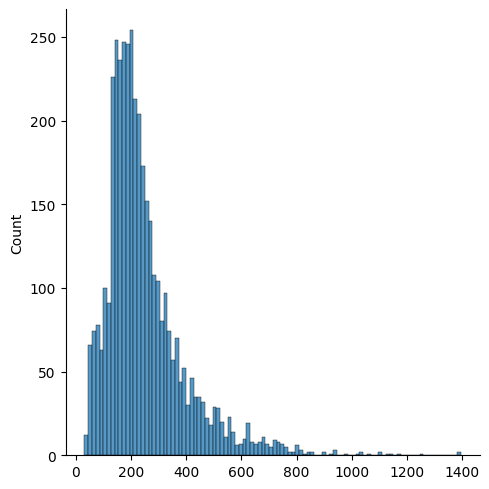

In [122]:
import seaborn as sns

#visualize the length of the songs

length = []
for song in dataset:
    length.append(len(song))
    
sns.displot(length, kde=False, bins=100)

In [19]:
import voicing as vc
voicing = vc.Voicing()

print(all_meta[4005]['song_name'])
id = 0
for i, data in enumerate(all_meta):
    if 'Giant Steps' in data['song_name']:
        id = i
        print(i)
        break

strings_array =  voicing.get_chords(dataset[id]) 
print(strings_array)


Message To A Friend
1474
['<style>', 'Up Tempo Swing', '|', '.', 'B', 'maj7', '.', 'D', 'dom7', '|', '.', 'G', 'maj7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '.', 'F#', 'dom7', '|', '.', 'B', 'maj7', '|', '.', 'F', 'm7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '|', '.', 'A', 'm7', '.', 'D', 'dom7', '|', '.', 'G', 'maj7', '|', '.', 'C#', 'm7', '.', 'F#', 'dom7', '|', '.', 'B', 'maj7', '|', '.', 'F', 'm7', '.', 'Bb', 'dom7', '|', '.', 'Eb', 'maj7', '|', '.', 'C#', 'm7', '.', 'F#', 'dom7']


In [20]:
import voicing as vc

#check the voicing conversion of all chords
from_ = 4005
to_ = 4006
myTracks = dataset[from_:to_]
sub_names = []
for names in all_meta[from_:to_]:
    sub_names.append(names['song_name'])
voicing = vc.Voicing()
midi_voicing = []


i = 0
for item in tqdm(myTracks):
    mv, status = voicing.convert_chords_to_voicing(item)
    midi_voicing.append(mv)
    if status == False:
        print(i, '\n', all_meta[i], '\n', item)
        break
    i += 1
print(len(midi_voicing))
print(sub_names)


100%|██████████| 1/1 [00:00<00:00, 1231.81it/s]

1
['Message To A Friend']


In [21]:
voicing = vc.Voicing()

#for i in range(len(midi_voicing)):
#    voicing.export_to_midi(midi_voicing[i], sub_names[i])


In [123]:
''' 
Count how many bars are in the all songs
Extend the form of the song to complete at least 64 bars
'''

bars = []
for song in dataset:
    number_of_bars = 0
    for i, e in enumerate(song):
        if e[0] == '|' or e[0] == 'e||' or e[0] == 'b||':
            number_of_bars += 1
    bars.append(number_of_bars)
    
print(len(bars))
print(bars)

repeat_times = 4
minimum = 64
new_dataset = []
for i, song in enumerate(dataset):
    new_song = []
    if bars[i] < minimum:
        #repeat the song again
        intro = song[0:2]
        s = song[2:]
        new_song = intro
        for i in range(repeat_times):
            new_song+=s
    
        new_dataset.append(new_song)
    else:
        new_dataset.append(song)

   

4006
[39, 41, 40, 37, 54, 73, 32, 46, 32, 33, 32, 53, 47, 33, 55, 20, 32, 30, 10, 36, 62, 42, 57, 28, 57, 32, 36, 10, 33, 50, 32, 32, 32, 32, 10, 64, 49, 38, 32, 80, 32, 29, 41, 68, 36, 13, 53, 36, 32, 24, 32, 22, 38, 32, 29, 44, 23, 32, 66, 68, 45, 33, 55, 53, 62, 28, 36, 32, 13, 23, 56, 32, 16, 36, 40, 28, 68, 33, 10, 33, 64, 26, 32, 32, 32, 75, 85, 68, 24, 47, 45, 45, 84, 40, 33, 48, 16, 26, 32, 32, 53, 40, 40, 32, 32, 32, 8, 35, 76, 76, 58, 58, 35, 43, 49, 128, 135, 96, 96, 55, 55, 55, 57, 53, 32, 32, 32, 74, 34, 92, 73, 32, 32, 32, 65, 65, 40, 40, 36, 33, 34, 167, 45, 32, 94, 32, 48, 32, 33, 40, 32, 93, 20, 20, 32, 48, 48, 10, 30, 32, 32, 40, 43, 24, 32, 32, 103, 32, 32, 37, 41, 53, 58, 52, 99, 36, 31, 32, 32, 53, 53, 32, 36, 34, 34, 52, 32, 64, 32, 97, 37, 37, 37, 44, 28, 36, 39, 39, 46, 44, 32, 34, 34, 32, 14, 70, 47, 47, 42, 42, 24, 24, 32, 49, 48, 24, 58, 49, 32, 31, 31, 32, 32, 21, 21, 41, 16, 64, 116, 38, 48, 52, 52, 51, 51, 65, 65, 59, 33, 44, 44, 46, 33, 37, 70, 69, 71, 71

4006
[156, 164, 160, 148, 216, 73, 128, 184, 128, 132, 128, 212, 188, 132, 220, 80, 128, 120, 40, 144, 248, 168, 228, 112, 228, 128, 144, 40, 132, 200, 128, 128, 128, 128, 40, 64, 196, 152, 128, 80, 128, 116, 164, 68, 144, 52, 212, 144, 128, 96, 128, 88, 152, 128, 116, 176, 92, 128, 66, 68, 180, 132, 220, 212, 248, 112, 144, 128, 52, 92, 224, 128, 64, 144, 160, 112, 68, 132, 40, 132, 64, 104, 128, 128, 128, 75, 85, 68, 96, 188, 180, 180, 84, 160, 132, 192, 64, 104, 128, 128, 212, 160, 160, 128, 128, 128, 32, 140, 76, 76, 232, 232, 140, 172, 196, 128, 135, 96, 96, 220, 220, 220, 228, 212, 128, 128, 128, 74, 136, 92, 73, 128, 128, 128, 65, 65, 160, 160, 144, 132, 136, 167, 180, 128, 94, 128, 192, 128, 132, 160, 128, 93, 80, 80, 128, 192, 192, 40, 120, 128, 128, 160, 172, 96, 128, 128, 103, 128, 128, 148, 164, 212, 232, 208, 99, 144, 124, 128, 128, 212, 212, 128, 144, 136, 136, 208, 128, 64, 128, 97, 148, 148, 148, 176, 112, 144, 156, 156, 184, 176, 128, 136, 136, 128, 56, 70, 188, 188, 1

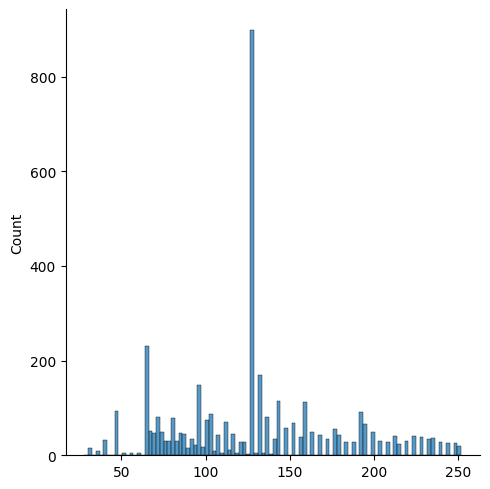

In [124]:
bars = []
for song in new_dataset:
    number_of_bars = 0
    for i, e in enumerate(song):
        if e[0] == '|' or e[0] == 'e||' or e[0] == 'b||':
            number_of_bars += 1
    bars.append(number_of_bars)
    
print(len(bars))
print(bars)

import seaborn as sns

#visualize the bars length of the songs
sns.displot(bars, kde=False, bins=100)

In [24]:
#check all tonalities
all_tonalities = [all_meta[i]['tonality'] for i in range(len(all_meta))]

all_tonalities = set(all_tonalities)
print(all_tonalities)

#get only the notes by splitting the tonalities
tonalities = [t.split(' ')[0] for t in all_tonalities]

#sort notes starting from A
tonalities = set(tonalities)
notes = sorted(tonalities, key=lambda x: (x, x[0]))
print(notes)


{'G major', 'D major', 'A major', 'G# minor', 'F major', 'D minor', 'C major', 'E minor', 'Bb major', 'Ab major', 'Db major', 'B major', 'Bb minor', 'B minor', 'Eb minor', 'A minor', 'F minor', 'Gb major', 'Eb major', 'G minor', 'C minor', 'E major', 'F# minor', 'C# minor'}
['A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'Db', 'E', 'Eb', 'F', 'F#', 'G', 'G#', 'Gb']


In [125]:
#Check songs after transposing test case

import transposition as tr

transpose = tr.Transposition()

#id = 1474
#id = 4005
id = 213
song_to_transpose = new_dataset[id]
tonality = all_meta[id]['tonality']
song_name = all_meta[id]['song_name']

print(song_to_transpose) 
tonal = 'C'
new_song = transpose.transpose_song(song_to_transpose, tonality, tonal)



[('<style>', 0.0), ('Ballad', 0.0), ('Form_intro', 0.0), ('|', 0.0), ('.', 4.0), ('A', 4.0), ('m', 4.0), ('|', 4.0), ('.', 4.0), ('D', 4.0), ('m6', 4.0), ('|', 4.0), ('.', 4.0), ('A', 4.0), ('m', 4.0), ('|', 4.0), ('.', 2.0), ('D', 2.0), ('m6', 2.0), ('.', 2.0), ('D', 2.0), ('m', 2.0), ('add 11', 2.0), ('Form_A', 2.0), ('|', 2.0), ('.', 2.0), ('A', 2.0), ('m7', 2.0), ('add 9', 2.0), ('.', 1.0), ('D', 1.0), ('m7', 1.0), ('.', 1.0), ('E', 1.0), ('m7', 1.0), ('|', 1.0), ('.', 2.0), ('F', 2.0), ('maj7', 2.0), ('.', 1.0), ('G', 1.0), ('dom7', 1.0), ('add 9', 1.0), ('.', 1.0), ('E', 1.0), ('dom7', 1.0), ('/', 1.0), ('G#', 1.0), ('|', 1.0), ('.', 2.0), ('A', 2.0), ('m7', 2.0), ('add 9', 2.0), ('.', 2.0), ('Ab', 2.0), ('maj7', 2.0), ('|', 2.0), ('.', 2.0), ('C', 2.0), ('maj7', 2.0), ('/', 2.0), ('G', 2.0), ('.', 2.0), ('F#', 2.0), ('m7', 2.0), ('alter b5', 2.0), ('|', 2.0), ('.', 2.0), ('F', 2.0), ('maj7', 2.0), ('.', 2.0), ('Eb', 2.0), ('maj6', 2.0), ('add 9', 2.0), ('|', 2.0), ('.', 2.0), ('

In [26]:
#Augment the dataset with all tonalities
dataset_augmented = []
meta_augmented = []
tonalities = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']

for i, song in enumerate(tqdm(new_dataset)):
    tonality = all_meta[i]['tonality']
    for tonal in tonalities:
        new_song = transpose.transpose_song(song, tonality, tonal)
        dataset_augmented.append(new_song)
        meta_augmented.append(all_meta[i])

print(len(dataset_augmented), len(meta_augmented))

100%|██████████| 4006/4006 [01:52<00:00, 35.48it/s]

48072 48072


In [27]:
#Extract all MIDI arrays from the dataset, check the sizes and normalize its size to eight values
# import voicing as vc
# voicing = vc.Voicing()

# midi_voicing_dataset = []
# for i, song in enumerate(tqdm(dataset_augmented)):
#     mv, _ = voicing.convert_chords_to_voicing(song)
#     midi_voicing_dataset.append(mv)

# print(len(midi_voicing_dataset))
midi_voicing_dataset = []

In [176]:
import voicing as vc
voicing = vc.Voicing()

id = 4005
test_this = new_dataset[id]
name = meta_augmented[id]['song_name']

midi_v, _ = voicing.convert_chords_to_voicing(test_this)

# for e in midi_v:
#     print(e)
    
voicing.export_to_midi(midi_v, name)

song: At The Jazz Band Ball
MIDI file created! 
---------------------------------


In [29]:
#find the maximum size of the midi voicing
max = -1
for i, song in enumerate(midi_voicing_dataset):
    for item in song:
        ar = item[0] 
        if len(ar) > max:
            max = len(ar)
        if len(ar) == 22:
            print(i, len(ar))
            
print(max)

-1


In [30]:
id = 22872
print(meta_augmented[id])
print(dataset_augmented[id])
print(midi_voicing_dataset[id])

for i, chord in enumerate(dataset_augmented[id]):
    midi = midi_voicing_dataset[id][i][0]
    print(i, chord, midi)

{'composer': 'Strayhorn-Ellington', 'style': 'Medium Swing', 'song_name': 'Isfahan', 'tonality': 'Db major', 'midi_key': 13, 'time_signature': '4/4', 'decade': 'Null'}
[('<style>', 0.0), ('Medium Swing', 0.0), ('Form_A', 0.0), ('|', 0.0), ('.', 4.0), ('C', 4.0), ('maj7', 4.0), ('|', 4.0), ('.', 2.0), ('A', 2.0), ('maj7', 2.0), ('.', 2.0), ('A', 2.0), ('dom7', 2.0), ('alter #5', 2.0), ('|', 2.0), ('.', 4.0), ('D', 4.0), ('dom7', 4.0), ('add 9', 4.0), ('|', 4.0), ('.', 4.0), ('D', 4.0), ('dom7', 4.0), ('add 9', 4.0), ('|', 4.0), ('.', 4.0), ('Ab', 4.0), ('maj7', 4.0), ('|', 4.0), ('.', 4.0), ('G', 4.0), ('dom7', 4.0), ('add 13', 4.0), ('add b9', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('maj7', 4.0), ('|', 4.0), ('.', 4.0), ('C', 4.0), ('maj7', 4.0), ('Form_B', 4.0), ('|', 4.0), ('.', 2.0), ('F#', 2.0), ('m7', 2.0), ('alter b5', 2.0), ('add b9', 2.0), ('.', 2.0), ('B', 2.0), ('dom7', 2.0), ('alter b5', 2.0), ('add b9', 2.0), ('|', 2.0), ('.', 4.0), ('E', 4.0), ('m6', 4.0), ('|', 4.0), (

IndexError: list index out of range

In [ ]:
name = all_meta[id]['song_name']
mv, status = voicing.convert_chords_to_voicing(new_song)
voicing.export_to_midi(mv, name)

song: Message To A Friend
MIDI file created! 
---------------------------------
